In [31]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
import optuna
import shap


## Carregar os dados

In [2]:
df_loan = pd.read_csv('./loan_data.csv')

In [3]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
df_loan.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

## Feature engenieer

In [5]:
for col in df_loan.select_dtypes(include=['object']).columns:
    print(f'Coluna: {col} \n{df_loan[col].unique()}')

Coluna: person_gender 
['female' 'male']
Coluna: person_education 
['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
Coluna: person_home_ownership 
['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Coluna: loan_intent 
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Coluna: previous_loan_defaults_on_file 
['No' 'Yes']


In [6]:
features_numericas = df_loan.select_dtypes(include=['number']).columns

tem_negativo = (df_loan[features_numericas] < 0).any().any()
tem_negativo

np.False_

In [7]:
df_loan['previous_loan_defaults_on_file'] = df_loan['previous_loan_defaults_on_file'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

## EDA

In [9]:
contagem = df_loan.value_counts('loan_status')/len(df_loan) * 100
px.bar(contagem, color=contagem.index)


In [10]:
features_categoricas = df_loan.select_dtypes(include=['object']).columns
for col in features_categoricas:
    contagem = df_loan.value_counts(col)/len(df_loan) * 100
    fig = px.bar(contagem, color=contagem.index)
    fig.show()

In [11]:
features_numericas = df_loan.select_dtypes(include=['number']).columns
df_loan[features_numericas].describe()


person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score  previous_loan_defaults_on_file   loan_status  
count  45000.000000                    45000.000000  45000.000000  
mean     632.608756                        0.507956      0.222222  
std       50.435865                        0.499942      0.415744  
min      390.000000                        0.000000      0.000000  
25%      601.000000                        0.000000      0.000000  
50%      640.000000                        1.000000      0.000000  
75%      670.000000                        1.000000      0.000000  
max      850.000000                        1.000000      1.000000

In [12]:

for col in features_numericas:
    if col != 'loan_status':
        fig = px.box(df_loan, x='loan_status', y=col,color='loan_status')
        fig.show()

In [13]:
# Correlação

corr_matrix = df_loan[features_numericas].corr()

fig = px.imshow(corr_matrix,
                title='Matriz de Correlação',
                color_continuous_scale='Viridis',
                zmin=-1,
                zmax=1)

fig.update_traces(
    text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 9}
)

fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

In [14]:
# Teste estatistico

colunas_categoricas =df_loan.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    contingency_table = pd.crosstab(df_loan['loan_status'],df_loan[col])
    chi2,p_value, dof, expected = chi2_contingency(contingency_table)

    print(f'\nTeste de Chi-quadrado para {col} x Loan Status')
    print(f'p-valor: {p_value}')

    if p_value <= 0.05:
        print(f'As variáveis {col} e Loan Status não são independentes')
    else:
        print(f'As variáveis {col} e Loan Status são independentes')



Teste de Chi-quadrado para person_gender x Loan Status
p-valor: 0.9142540404277906
As variáveis person_gender e Loan Status são independentes

Teste de Chi-quadrado para person_education x Loan Status
p-valor: 0.732826935503778
As variáveis person_education e Loan Status são independentes

Teste de Chi-quadrado para person_home_ownership x Loan Status
p-valor: 0.0
As variáveis person_home_ownership e Loan Status não são independentes

Teste de Chi-quadrado para loan_intent x Loan Status
p-valor: 2.1730841870538932e-194
As variáveis loan_intent e Loan Status não são independentes


# Preparação dos dados

In [15]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [16]:
for col in colunas_categoricas:
    print(df_loan[col].unique())

['female' 'male']
['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']


In [17]:
X = df_loan.drop(columns=['loan_status'], axis=1)
y = df_loan['loan_status']

colunas_numericas = X.select_dtypes(include=['number']).columns
colunas_categoricas = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=51, test_size=0.5)

In [18]:

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas),
        ('num', StandardScaler(),colunas_numericas)
    ]
)

In [19]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Treinar modelo

In [20]:

param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 10,20,30],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [1,2,5,10]
}


In [21]:
rf_model_cv = RandomForestClassifier(class_weight='balanced',random_state=51, max_features='sqrt')
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid,cv=kfolds, scoring='recall', verbose=2)

In [22]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=51, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=51),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

In [23]:
best_model = grid_search.best_estimator_

best_params = grid_search.best_params_

In [24]:
best_params

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 50}

In [25]:
best_score = grid_search.best_score_
best_score

np.float64(0.8989751972714981)

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
y_pred

array([0, 0, 1, ..., 1, 0, 0], shape=(22500,))

In [28]:
y_pred_proba = best_model.predict_proba(X_test)

In [29]:
y_pred_proba

array([[0.98984479, 0.01015521],
       [0.66416776, 0.33583224],
       [0.04848615, 0.95151385],
       ...,
       [0.02073629, 0.97926371],
       [0.98532447, 0.01467553],
       [0.95709054, 0.04290946]], shape=(22500, 2))

In [30]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     17479
           1       0.69      0.91      0.78      5021

    accuracy                           0.89     22500
   macro avg       0.83      0.90      0.85     22500
weighted avg       0.91      0.89      0.89     22500



In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [33]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [34]:
# Plotar a Curva ROC 
fig = px.area(
    x=fpr,
    y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700,
    height=500
)

fig.add_shape(
    type='line',
    line=dict(dash='dash'),
    x0=0,x1=1,y0=0,y1=1
)

fig.update_yaxes(scaleanchor='x',scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

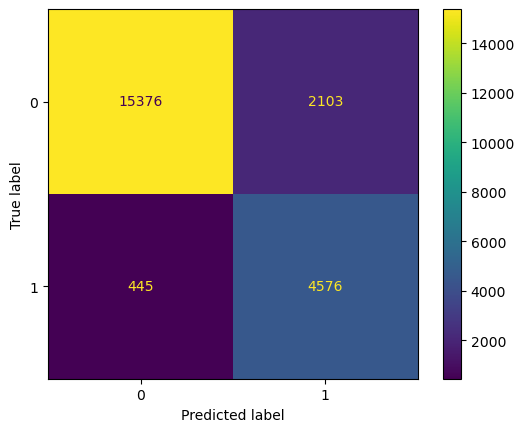

In [35]:

conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [36]:
# calcular log loss
print(f'Log loss: {log_loss(y_test,y_pred_proba):.4f}')

Log loss: 0.2445


## Ajustar Threshold

In [43]:
# Criar uma lista de thresholds para testar
thresholds = [0.3,0.4,0.5,0.6,0.7]

# Lista para armazenar métrica
precisions = []

# Calcular as métricas para cada threshold

for threshold in thresholds:
    # Fazer predições com o threshold
    y_pred_threshold = (y_pred_proba[:,1] >= threshold).astype(int)
    precision = precision_score(y_test,y_pred_threshold)

    # Inserir métrica na lista
    precisions.append(precision)


In [44]:
df_result = pd.DataFrame({'Threshold': thresholds, 'Precisions': precisions})

In [45]:
melhor_threshold = df_result.loc[df_result['Precisions'].idxmax()]

print(f'Maior Threshold : {melhor_threshold['Threshold']}')
print(f'Maior Precisao : {melhor_threshold['Precisions']:.4f}')

Maior Threshold : 0.7
Maior Precisao : 0.8937


In [46]:
# Plotar um gráfico com Threshold
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=thresholds, y=precisions, name='Precision', line=dict(color='blue'))
)

fig.update_layout(
    title='Precision por Threshold',
    xaxis_title='Precision Score',
    yaxis_title='Threshold',
    width=800,
    height=500
)

## Análise de métricas com o threshold

In [47]:
# Fazer predições
y_pred = (y_pred_proba[:,1] >= melhor_threshold['Threshold']).astype(int)

In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     17479
           1       0.89      0.74      0.81      5021

    accuracy                           0.92     22500
   macro avg       0.91      0.86      0.88     22500
weighted avg       0.92      0.92      0.92     22500



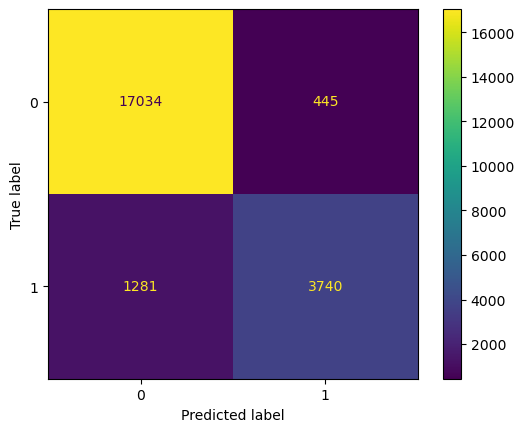

In [49]:
# Mostrar a matriz de confusão

conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix)
fig.plot()

In [50]:
# calcular log loss
print(f'Log loss: {log_loss(y_test,y_pred_proba):.4f}')

Log loss: 0.2445
